In [326]:
import torch
from torch.nn import Linear, Parameter
import torch_geometric
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax, dropout_edge
from torch_geometric.data import Data
import torch_geometric.loader as loader
from torch_geometric.nn.pool import global_mean_pool, global_max_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Literal
import copy
from torch_geometric.nn.norm import BatchNorm
from tqdm import tqdm
import numpy as np
from torch_geometric.loader import DataLoader
from itertools import zip_longest
from torch.utils.tensorboard import SummaryWriter
import datetime
from matplotlib import collections  as mc

In [327]:
from torch_geometric.datasets import ZINC
zinc_dataset = ZINC(root = './data', split='train')
zinc_dataset_val = ZINC(root = './data', split='val')

In [328]:
# Fix edge attributes being indexed from 1 
zinc_dataset.edge_attr -= 1
zinc_dataset_val.edge_attr -= 1

In [329]:
num_atom_types = zinc_dataset.x.unique().shape[0]
print(f'There are {num_atom_types} atom types')

num_bond_types = zinc_dataset.edge_attr.unique().shape[0]
print(f'There are {num_bond_types} bond types')

There are 28 atom types
There are 3 bond types


In [330]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [331]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class MPCell(MessagePassing):
    def __init__(self, in_channels, 
                 out_channels, 
                 in_edge_channels, 
                 out_edge_channels=None, 
                 dropout=0.2,
                 **kwargs):
        super(MPCell, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.in_edge_channels = in_edge_channels
        self.out_edge_channels = out_edge_channels

        self.msg = torch.nn.Sequential(
            torch.nn.Linear(2*in_channels+in_edge_channels, out_channels),
            torch.nn.ReLU(),
        )

        self.update_edges = out_edge_channels is not None
        if self.update_edges:
            self.edge_nn = nn.Sequential(
                torch.nn.Linear(2*out_channels+in_edge_channels, out_edge_channels),
                nn.ReLU()
            )
        
        self.norm = BatchNorm(out_channels)

        self.up = torch.nn.Sequential(
            torch.nn.Linear(out_channels, out_channels),
            torch.nn.SELU()
        )

    def __str__(self):
        str = f'MP Cell: \nin_channels={self.in_channels}, \nout_channels={self.out_channels} \n'
        str += f'in_edge_channels={self.in_edge_channels}, \nout_edge_channels={self.out_edge_channels}\n'
        return str


    def edge_update(self, edge_attr, x_i, x_j) -> torch.Tensor:
        return self.edge_nn(torch.cat([edge_attr,x_i,x_j], dim=-1))
        

    def forward(self, x, edge_index, edge_attr, batch_index):
        x = F.dropout(x, p=self.dropout, training=self.training)

        
        out_x = self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr)
        
        if self.update_edges:
            edge_attr = self.edge_updater(edge_index=edge_index,
                                            edge_attr=edge_attr,
                                            x=out_x)
        
        out_x = self.norm(out_x)

        return self.up(out_x), edge_attr


    def message(self, x_i, x_j, edge_attr):
        
        return self.msg(torch.cat([x_i,x_j,edge_attr], dim=-1))


In [372]:
batch_size = 256
train_loader = DataLoader(zinc_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(zinc_dataset_val, batch_size=batch_size, shuffle=True)

In [333]:
batch = next(iter(train_loader))

In [342]:
class MP_GNN(torch.nn.Module):
    def __init__(self, num_atoms, hidden_sizes, num_bonds, edge_hidden_sizes, dropout=0.2):
        super().__init__()

        self.layers = nn.ModuleList()
        self.skip_connections = nn.ModuleList()

        self.atom_embedding = nn.Embedding(num_atoms, hidden_sizes[0], scale_grad_by_freq=True)
        self.edge_embedding = nn.Embedding(num_bonds, edge_hidden_sizes[0], scale_grad_by_freq=True)

        self.dropout = dropout

        in_features =  hidden_sizes[0]
        edge_features = edge_hidden_sizes[0]


        for n_hs, e_hs in zip_longest(hidden_sizes[1:], edge_hidden_sizes[1:]):
            mp_cell = MPCell(in_channels=in_features, out_channels=n_hs, in_edge_channels=edge_features,
                             out_edge_channels=e_hs, dropout=dropout)
            
            self.skip_connections.append(nn.Identity() if in_features == n_hs else nn.Linear(in_features, n_hs))
            in_features = n_hs
            edge_features = e_hs if e_hs is not None else edge_features

            self.layers.append(mp_cell)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_sizes[-1], hidden_sizes[-1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[-1], 1),
        )

    def tmp(self):
        for layer, skip_conn in zip(self.layers, self.skip_connections):
            print(layer, skip_conn)  

    def forward(self, x, edge_index, batch_index, edge_attr):

        x = self.atom_embedding(x).squeeze(1)
        edge_attr = self.edge_embedding(edge_attr).squeeze(1)
        
        for layer, skip_conn in zip(self.layers, self.skip_connections):
            x_, edge_attr = layer(x=x, edge_index=edge_index, edge_attr=edge_attr, batch_index=batch_index)
            x = x_ + skip_conn(x)


        x = global_mean_pool(x, batch_index)

        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.regressor(x)

        

In [343]:
model = MP_GNN(num_atoms=num_atom_types, 
               hidden_sizes=[128,128,128,128], 
               num_bonds=num_bond_types, 
               edge_hidden_sizes=[8,8,8], dropout=0.3)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'Parameters: {count_parameters(model=model)}')

Parameters: 176553


In [344]:
model = model.to(device)

In [348]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4) 

In [349]:
def train(batch, step_optimizer=True):
    '''
    Forwards a batch of data and optimizes the params
    '''
    batch = batch.to(device)
    
    model.train()
    optimizer.zero_grad()

    output = model(x=batch.x, 
                   edge_index=batch.edge_index, 
                   edge_attr=batch.edge_attr, 
                   batch_index=batch.batch)
    
    loss = loss_fn(output.squeeze(1), batch.y)

    loss.backward()
    if step_optimizer:
        optimizer.step()


    return loss.item()


def validate(batch):
    batch = batch.to(device)

    model.eval()

    with torch.no_grad():
        output = model(x=batch.x, 
                   edge_index=batch.edge_index, 
                   edge_attr=batch.edge_attr, 
                   batch_index=batch.batch)
        
        return loss_fn(output.squeeze(1), batch.y).item()
    

def validation_step():
    loss_sum = 0
    for batch in val_loader:
        loss_sum += validate(batch)
    return loss_sum / len(val_loader)
        

In [50]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12063), started 0:00:06 ago. (Use '!kill 12063' to kill it.)

In [350]:
epochs = 100
average_over = 100
validate_every = 1000
losses = []
val_losses = []
run_name = f'run_{datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}'

writer = SummaryWriter(log_dir=f'runs/{run_name}')

global_counter = 0


for e in range(1, epochs+1):
    loss_sum = 0
    loss_count = 0

    progress_bar = tqdm(total=len(train_loader), position=0, leave=False)
    for i, batch in enumerate(train_loader):

        train_loss = train(batch=batch, step_optimizer=True)

        loss_sum += train_loss
        loss_count += 1

        if i % average_over == average_over - 1:
            losses.append(loss_sum / loss_count)
            loss_sum = 0
            loss_count = 0

            progress_bar.set_description(f"EPOCH[{e}/{epochs}] Loss: {losses[-1]:.4f}\t")
            writer.add_scalar('Loss/train', losses[-1], global_counter)

            
        progress_bar.update(1)

        if global_counter % validate_every == validate_every - 1:
            progress_bar.set_description(f"EPOCH[{e}/{epochs}] Validating ... \t")

            val_losses.append(validation_step())
            writer.add_scalar('Loss/val', val_losses[-1], global_counter)

        global_counter += 1

EPOCH[100/100] Validating ... 	: 100%|██████████| 860/860 [00:12<00:00, 83.50it/s]

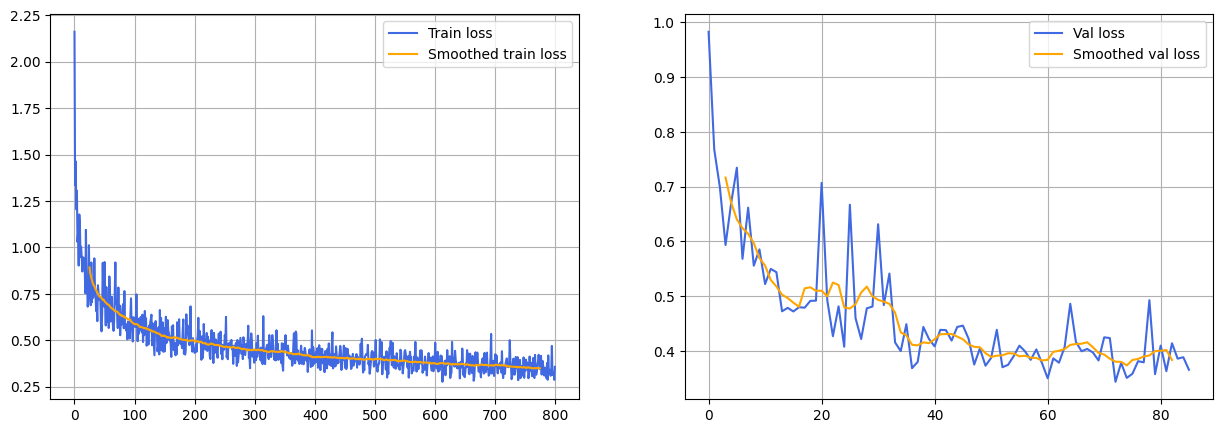

In [396]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))


# xticks_train = [average_over*i for i in range(1, len(losses)+1)]
axes[0].plot(losses, label='Train loss', color='royalblue')
# xticks_val = [validate_every*i for i in range(1, len(val_losses)+1)]
axes[1].plot(val_losses, label='Val loss', color='royalblue')

window = 51
axes[0].plot([k for k in range(window//2, len(losses)- window//2)], np.convolve(losses, 
                           np.ones(window)*(1/window), mode='valid'), color='orange', label='Smoothed train loss')

val_window = 7
axes[1].plot([k for k in range(val_window//2, len(val_losses)- val_window//2)], np.convolve(val_losses, 
                           np.ones(val_window)*(1/val_window), mode='valid'), color='orange', label='Smoothed val loss')



axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()


/tmp/ipykernel_834/1899545077.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


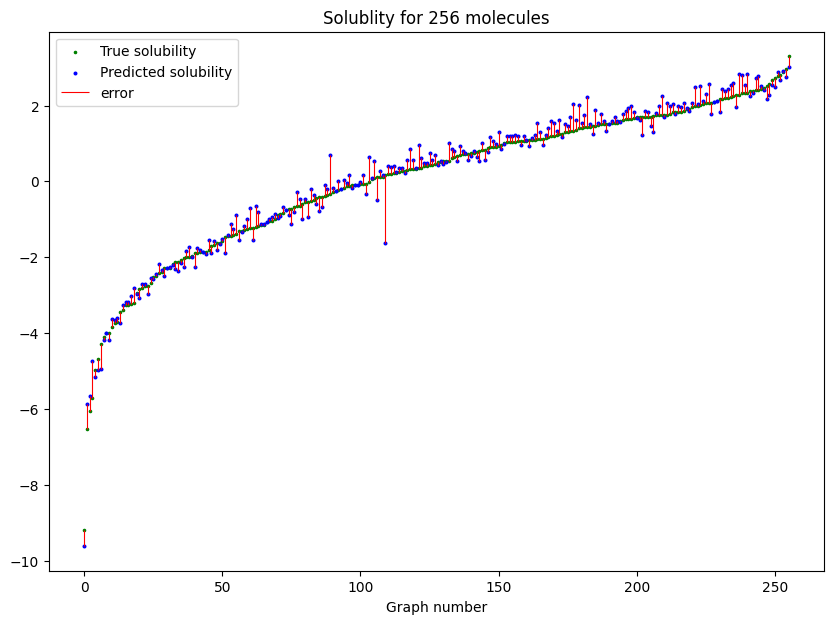

In [380]:
fig, ax = plt.subplots(figsize=(10, 7))



_, batch = next(enumerate(val_loader))
batch = batch.to(device)

with torch.no_grad():
    model.eval()
    out = model(x=batch.x, 
                   edge_index=batch.edge_index, 
                   edge_attr=batch.edge_attr, 
                   batch_index=batch.batch)
    
    
sorted_y, sorted_indices = torch.sort(batch.y)


y1 = sorted_y.cpu()
y2 = out.reshape(-1,)[sorted_indices].cpu()

# create lines between true and predicted value
lines = []
i=0
for true, pred in zip(y1, y2):
    lines.append([(i,true),(i,pred)])
    i += 1
    
lc = mc.LineCollection(lines, linewidths=0.8, color='red', label='error')

ax.scatter([i for i in range(len(batch.y))], y1, s=2.5, label='True solubility', color='green')
ax.scatter([i for i in range(len(batch.y))], y2, s=3.5, label='Predicted solubility', color='blue')
ax.add_collection(lc)

ax.set_xlabel('Graph number')

ax.set_title(f'Solublity for {len(batch)} molecules')
ax.legend()
fig.show()